# KNN (k nearest neighbours) - K najbliższych sąsiadów

Jeden z algorytmów uczenia nadzorowanego służący do klasyfikacji i regresji.
Zasada działania algorytmu w zadaniu klasyfikacji polega na przydzieleniu klasy decyzyjnej, którą obiekty w określonym zasięgu najliczniej reprezentują.
W zadaniu regresji predykcja przydzielana jest na podstawie uśrednionej predykcji obiektów znajdujących się w określonym zasięgu.
Zasięgiem w przypadku algorytmu KNN jest liczba najbliższych sąsiadów, czyli obiektów pochodzących z systemu decyzyjnego umieszczonych w przestrzeni n-wymiarowej.

![knn](img/knn.svg) (źródło: wikimedia)

## Metody obliczania podobieństwa między obiektami

Do ustalania podobieństwa między obiektami służą metryki odległości.

### Metryka Euklidesa
$d(x, y) = \sqrt{\sum^n_{i=0} (x_i - y_i)^2}$

### Metryka Manhattan
$d(x, y) = \sum_{i=0}^n |x_i - y_i|$

### Metryka Mahalanobisa
$d(x, y) = \sqrt{\sum_{i=1}^n \frac{(x_i - y_i)^2}{s_i^2}}$

## Metody wyboru optymalnej wartości K

Polega na ustawieniu wartości K na podstawie pewnej wiedzy eksperckiej. Przykładowo, w klasyfikacji aktualnej pogody na podstawie bieżących warunków atmosferycznych k=7 jest dobrym wyborem.
### Wybór deterministyczny

### Metody heurystyczne
- Zastosowanie względnie pierwszych kombinacji liczby klas i wartości K. W tym celu należy dobrać obie wartości w taki sposób, aby ich jedynym wspólnym dzielnikiem była liczba 1.
- Wartość K większa lub równa od liczby klas powiększone o 1

## Przykład - przewidywanie cen domów

Dany jest zbiór zawierający ceny domów wraz z atrybutami takimi jak współrzędne geograficzne, wielkość działki, bliskość centrum miasta itd.
Celem przykładu jest przewidywanie cen domów na podstawie atrybutów: szerokość geograficzna, długość geograficzna oraz wielkość działki przy użyciu regresji KNN.

### Wczytanie systemu decyzyjnego i wstępna eksploracja

In [77]:
import random
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
from sklearn.metrics import mean_absolute_error


In [78]:
houses = pd.read_csv('data/data.csv')

houses.head(3)

,AppraisedValue,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,...,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,WaterProblems,TranspConcurrency,OtherProblems,lat,long
0,619000.0,6542712,1,1,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,47.354019,-122.225166
1,708000.0,105850,2,1,3,0,2,0,0,0,...,0,0,0,0,0,0,0,0,47.611248,-122.053154
2,297000.0,1667,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.701248,-122.365784


W obiekcie values umieszczamy atrybut decyzyjny z oryginalnego systemu decyzyjnego,
następnie usuwamy atrybut z systemu decyzyjnego uzyskując w ten sposób system informacyjny w obiekcie houses.

In [79]:
values = houses['AppraisedValue']
houses.drop('AppraisedValue', 1, inplace=True)

Dokonujemy normalizacji danych w systemie informacyjnym (zerowa średnia arytmetyczna i jednostkowe odchylenie standardowe), oraz usuwamy zbędne atrybuty pozostawiając
jedynie współrzędne geograficzne i wielkość działki. Na podstawie tych atrybutów będziemy przewidywać docelowe ceny domów.

In [80]:
houses = (houses - houses.mean()) / (houses.max() - houses.min())
houses = houses[['lat', 'long', 'SqFtLot']]

Tworzymy obiekt regressora KNN

In [81]:
kdtree = KDTree(houses)


Następnie tworzymy funkcję, która przydzieli prognozę przekazanemu obiektowi na podstawie liczby najbliższych sąsiadów (parametr k).

In [82]:
def predict(query_point, k):
    _, idx = kdtree.query(query_point, k)
    return np.mean(values.iloc[idx])

Tworzymy następnie systemy decyzyjne służące do trenowania i testowania modelu.
System treningowy będzie zawierał 80% obiektów z oryginalnego systemu decyzyjnego, a system testowy 20%.

In [83]:
test_rows = random.sample(houses.index.tolist(), int(round(len(houses) * .2)))  # 20%
train_rows = set(range(len(houses))) - set(test_rows)
df_test = houses.loc[test_rows]
df_train = houses.drop(test_rows)
test_values = values.loc[test_rows]
train_values = values.loc[train_rows]


Dla wartości K (liczba najbliższych sąsiadów) równej 5 dokonujemy regresji obiektów pochodzących z systemu testowego,
a następnie porównujemy wyniki z wynikami oryginalnymi przy użyciu funkcji średniego błędu bezwzględnego.

In [84]:
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 5))
    train_actual_values.append(train_values[_id])

In [85]:
print(f'Wartosc sredniego bledu bezwzglednego na systemie treningowym dla k=5 wynosi: {mean_absolute_error(train_predicted_values, train_actual_values)}')

Wartosc sredniego bledu bezwzglednego na systemie treningowym dla k=5 wynosi: 59408.062972148036


In [86]:
error_k_5=mean_absolute_error(train_predicted_values, train_actual_values)

k=3

In [87]:
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 3))
    train_actual_values.append(train_values[_id])

In [88]:
error_k_3=mean_absolute_error(train_predicted_values, train_actual_values)

k=7

In [89]:
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 7))
    train_actual_values.append(train_values[_id])

In [90]:
error_k_7=mean_absolute_error(train_predicted_values, train_actual_values)

k=9

In [91]:
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 9))
    train_actual_values.append(train_values[_id])

In [92]:
error_k_9=mean_absolute_error(train_predicted_values, train_actual_values)

k=11

In [93]:
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 11))
    train_actual_values.append(train_values[_id])

In [94]:
error_k_11=mean_absolute_error(train_predicted_values, train_actual_values)

In [95]:
error_k_3,error_k_5,error_k_7,error_k_9,error_k_11

(52171.881581457455,
 59408.062972148036,
 63139.980657600696,
 65610.62839671032,
 67331.57577780861)

In [96]:
k=[3,5,7,9,11]
MAE=[error_k_3,error_k_5,error_k_7,error_k_9,error_k_11]

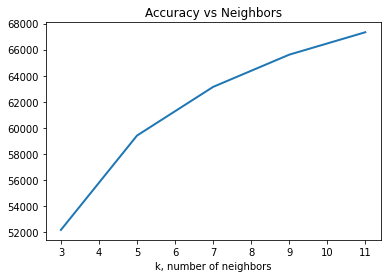

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k,MAE,linewidth=2, markersize=12)
plt.title("Accuracy vs Neighbors")
plt.xlabel("k, number of neighbors")
plt.ylabel=("Classification accuracy")
plt.show()

#### 60% system treningowy i 40% system testowy

In [98]:
test_rows = random.sample(houses.index.tolist(), int(round(len(houses) * .4)))  # 40%
train_rows = set(range(len(houses))) - set(test_rows)
df_test = houses.loc[test_rows]
df_train = houses.drop(test_rows)
test_values = values.loc[test_rows]
train_values = values.loc[train_rows]

In [99]:
#k=5
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 5))
    train_actual_values.append(train_values[_id])

In [100]:
error_k_5=mean_absolute_error(train_predicted_values, train_actual_values)

In [101]:
#k=3
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 3))
    train_actual_values.append(train_values[_id])

In [102]:
error_k_3=mean_absolute_error(train_predicted_values, train_actual_values)

In [103]:
#k=7
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 7))
    train_actual_values.append(train_values[_id])

error_k_7=mean_absolute_error(train_predicted_values, train_actual_values)

In [104]:
#k=9
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 9))
    train_actual_values.append(train_values[_id])

error_k_9=mean_absolute_error(train_predicted_values, train_actual_values)

In [105]:
k=[3,5,7,9,11]
MAE=[error_k_3,error_k_5,error_k_7,error_k_9,error_k_11]

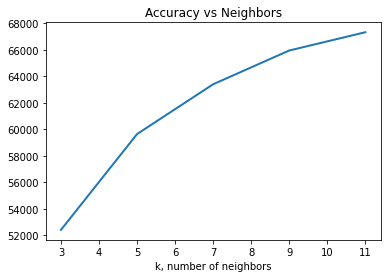

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k,MAE,linewidth=2, markersize=12)
plt.title("Accuracy vs Neighbors")
plt.xlabel("k, number of neighbors")
plt.ylabel=("Classification accuracy")
plt.show()

#### 65% system treningowy i 35% system testowy

In [107]:
test_rows = random.sample(houses.index.tolist(), int(round(len(houses) * .35)))  # 35%
train_rows = set(range(len(houses))) - set(test_rows)
df_test = houses.loc[test_rows]
df_train = houses.drop(test_rows)
test_values = values.loc[test_rows]
train_values = values.loc[train_rows]

In [108]:
#k=3
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 3))
    train_actual_values.append(train_values[_id])

error_k_3=mean_absolute_error(train_predicted_values, train_actual_values)

In [109]:
#k=5
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 5))
    train_actual_values.append(train_values[_id])

error_k_5=mean_absolute_error(train_predicted_values, train_actual_values)

In [110]:
#k=7
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 7))
    train_actual_values.append(train_values[_id])

error_k_7=mean_absolute_error(train_predicted_values, train_actual_values)

In [111]:
#k=9
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 9))
    train_actual_values.append(train_values[_id])

error_k_9=mean_absolute_error(train_predicted_values, train_actual_values)

In [112]:
k=[3,5,7,9,11]
MAE=[error_k_3,error_k_5,error_k_7,error_k_9,error_k_11]

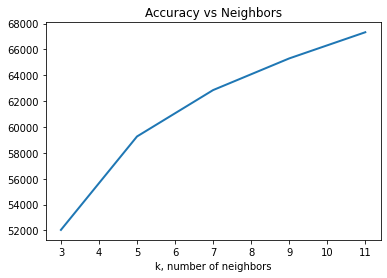

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k,MAE,linewidth=2, markersize=12)
plt.title("Accuracy vs Neighbors")
plt.xlabel("k, number of neighbors")
plt.ylabel=("Classification accuracy")
plt.show()

#### 70% system treningowy i 30% system testowy

In [114]:
test_rows = random.sample(houses.index.tolist(), int(round(len(houses) * .30)))  # 30%
train_rows = set(range(len(houses))) - set(test_rows)
df_test = houses.loc[test_rows]
df_train = houses.drop(test_rows)
test_values = values.loc[test_rows]
train_values = values.loc[train_rows]

In [115]:
#k=3
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 3))
    train_actual_values.append(train_values[_id])

error_k_3=mean_absolute_error(train_predicted_values, train_actual_values)

In [116]:
#k=5
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 5))
    train_actual_values.append(train_values[_id])

error_k_5=mean_absolute_error(train_predicted_values, train_actual_values)

In [117]:
#k=7
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 7))
    train_actual_values.append(train_values[_id])

error_k_7=mean_absolute_error(train_predicted_values, train_actual_values)

In [118]:
#k=9
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 9))
    train_actual_values.append(train_values[_id])

error_k_9=mean_absolute_error(train_predicted_values, train_actual_values)

In [119]:
k=[3,5,7,9,11]
MAE=[error_k_3,error_k_5,error_k_7,error_k_9,error_k_11]

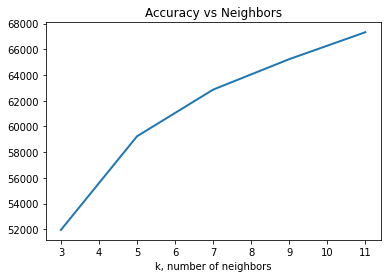

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k,MAE,linewidth=2, markersize=12)
plt.title("Accuracy vs Neighbors")
plt.xlabel("k, number of neighbors")
plt.ylabel=("Classification accuracy")
plt.show()

#### 75% system treningowy i 25% system testowy

In [123]:
test_rows = random.sample(houses.index.tolist(), int(round(len(houses) * .25)))  # 25%
train_rows = set(range(len(houses))) - set(test_rows)
df_test = houses.loc[test_rows]
df_train = houses.drop(test_rows)
test_values = values.loc[test_rows]
train_values = values.loc[train_rows]

In [124]:
#k=3
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 3))
    train_actual_values.append(train_values[_id])

error_k_3=mean_absolute_error(train_predicted_values, train_actual_values)

In [125]:
#k=5
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 5))
    train_actual_values.append(train_values[_id])

error_k_5=mean_absolute_error(train_predicted_values, train_actual_values)

In [126]:
#k=7
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 3))
    train_actual_values.append(train_values[_id])

error_k_7=mean_absolute_error(train_predicted_values, train_actual_values)

In [127]:
#k=9
train_predicted_values = []
train_actual_values = []

for _id, row in df_train.iterrows():
    train_predicted_values.append(predict(row, 3))
    train_actual_values.append(train_values[_id])

error_k_9=mean_absolute_error(train_predicted_values, train_actual_values)

In [128]:
k=[3,5,7,9,11]
MAE=[error_k_3,error_k_5,error_k_7,error_k_9,error_k_11]

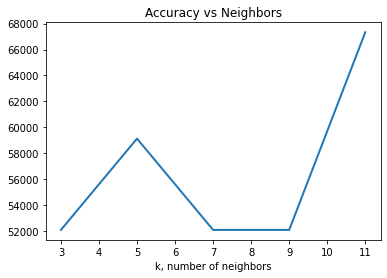

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k,MAE,linewidth=2, markersize=12)
plt.title("Accuracy vs Neighbors")
plt.xlabel("k, number of neighbors")
plt.ylabel=("Classification accuracy")
plt.show()

## Zadania - regresja KNN

1. Wykorzystać powyższy przykład w celu znalezienia takiej wartości K, dla której wartość średniego błędu bezwzględnego na systemie treningowym
będzie najmniejsza. W tym celu należy stworzyć wykres liniowy, na którym oś x będzie przedstawiała wartość K,
a oś y będzie przedstawiała wartość funkcji błędu. Następnie dla "najlepszej" wartości K sprawdzić wartość funkcji błędu
na systemie testowym.

2. Znaleźć "najlepszą" wartość K dla następujących podziałów na system treningowy i testowy:
    - 60% system treningowy i 40% system testowy
    - 65% system treningowy i 35% system testowy
    - 70% system treningowy i 30% system testowy
    - 75% system treningowy i 25% system testowy


## Klasyfikacja przy użyciu metody KNN

Przydział odpowiedniej klasy decyzyjnej w klasyfikatorze KNN polega na sprawdzeniu która klasa decyzyjna występuje
najliczniej wśród k najbliższych sąsiadów, co przy użyciu języka python można wyrazić następująco:

In [122]:
def classify(query_point, k):
    _, idx = kdtree.query(query_point, k)
    return np.argmax(np.bincount(values.iloc[idx]))

Funkcja zwraca dominantę klasy decyzyjnej występującej najczęściej wśród k najbliższych sąsiadów.
Atrybut decyzyjny w funkcji należy wskazać samodzielnie.

### Pomiar wydajności modeli w zadaniach klasyfikacji

#### Binarna entropia krzyżowa

Binarna entropia krzyżowa jest miarą błędu w zadaniach klasyfikacji binarnej:

$$ Err = - \frac{1}{N} \sum_{i=1}^{N} y_i log(\hat{y}_i) + (1 - y_i) log(1 - \hat{y}_i) $$

gdzie:
- $$ y_i $$ oznacza oryginalną klasę decyzyjną
- $$ \hat{y}_i $$ oznacza prawdopodobieństwo przynależności do pozytywnej klasy decyzyjnej przydzielone przez model
- $$ N $$ oznacza liczbę obiektów w systemie decyzyjnym

#### Kategorialna entropia krzyżowa

Binarna entropia krzyżowa jest miarą błędu w zadaniach klasyfikacji wieloklasowej:

$$ Err = - \sum_{i=1}^{N} y_i log(\hat{y}_i) $$

#### Dokładność

Dokładność to miara dokładności klasyfikacji wyrażona w formie odsetka obiektów, które otrzymały poprawną decyzję:

$$ Acc_{glob} = \frac{correct}{total} $$

gdzie:
- $$correct$$ oznacza liczbę obiektów, które otrzymały poprawną decyzję
- $$ total $$ oznacza liczbę obiektów w systemie decyzyjnym

#### Dokładność zbalansowana

Dokładność zbalansowana to miara dokładności stosowana w przypadku gdy liczebności klas w systemie decyzyjnym są różne.
Dokładność zbalansowaną można wyrazić jako uśrednioną dokładność klasyfikacji w obrębie każdej klasy decyzyjnej w systemie decyzyjnym.

$$ Acc_{balanced} = \frac{acc_{c_1} + acc_{c_2} + ... + acc_{c_k}}{k} $$

gdzie:
- k oznacza liczbę wszystkich klas decyzyjnych
- $$ acc_{c_k} $$ oznacza dokładność klasy decyzyjnej $$k$$

## Zadania - klasyfikacja KNN

1. Korzystając ze źródła http://archive.ics.uci.edu/ml/datasets.php wybrać jeden system decyzyjny, a następnie dokonać
klasyfikacji metodą KNN dowolnego atrybutu decyzyjnego. Wykorzystując rozwiązanie zadania 1 z regresji KNN znaleźć
najlepszą wartość K w następujących podziałach:
    - 55% system treningowy i 45% system testowy
    - 60% system treningowy i 40% system testowy
    - 65% system treningowy i 35% system testowy
    - 70% system treningowy i 30% system testowy
    - 75% system treningowy i 25% system testowy
    - 80% system treningowy i 20% system testowy

Dla każdego podziału zaprezentować poznane wartości miar wydajności modeli - w tym celu należy zaimplementować te funkcjonalności.